In [1]:
!pip install matplotlib==3.4.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import os

In [3]:
data_folder = "./drive/MyDrive/NetREx_Data/"

## PCA

In [4]:
def get_pca(filename, flag= False):
    df = pd.read_csv(filename)
    if flag:
        rdf = df[(df['pval_1hr']<0.05) & (df['pval_3hr']<0.05) & (df['pval_6hr']<0.05) & (df['pval_12hr']<0.05) & (df['pval_1day']<0.05)]
    else:
        rdf = df
    
    print(len(rdf))
    x = rdf[['FC_1hr','FC_3hr','FC_6hr','FC_12hr','FC_1day']].T.values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents,columns = ['pc1', 'pc2'])
    
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    ax.scatter(principalDf['pc1'], principalDf['pc2'])
    ax.grid()
    
    timepoints = ['1hr', '3hr', '6hr', '12hr', '1day']
    for i, txt in enumerate(timepoints):
        ax.annotate(txt, (principalDf.pc1[i], principalDf.pc2[i]))

2970
8809


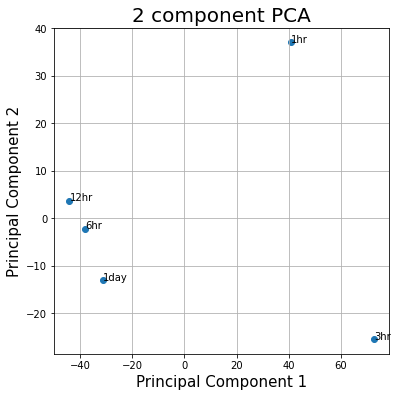

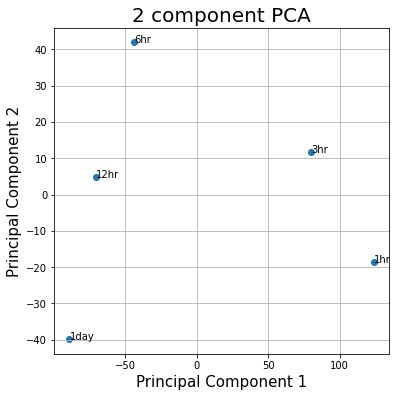

In [5]:
get_pca(data_folder+'ROOT/networks/drought_full.csv')
get_pca(data_folder+'SHOOT/networks/drought_full.csv')

2347
5791


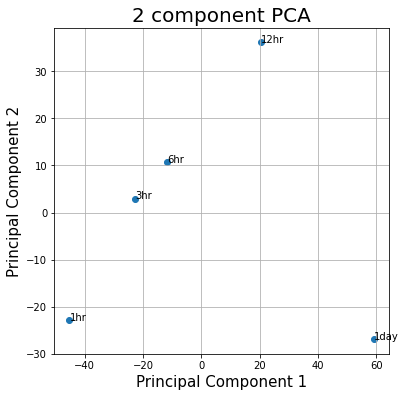

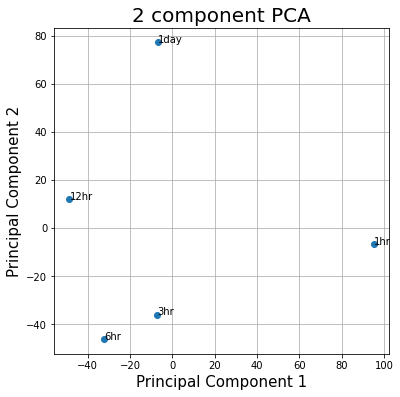

In [6]:
get_pca(data_folder+'ROOT/networks/flood_full.csv')
get_pca(data_folder+'SHOOT/networks/flood_full.csv')

5005
3688


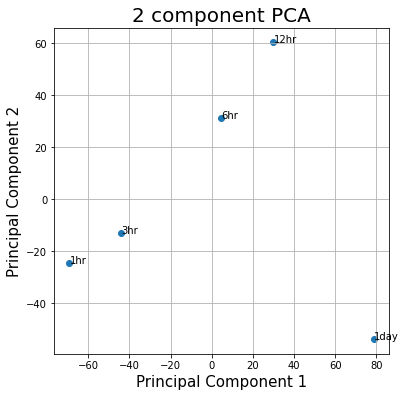

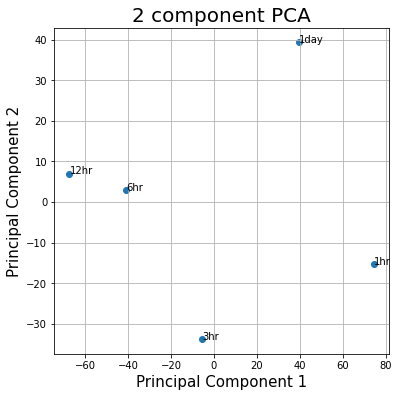

In [7]:
get_pca(data_folder+'ROOT/networks/cold_full.csv')
get_pca(data_folder+'SHOOT/networks/cold_full.csv')

These PCA plot indicates that for 

Root tissue: Lots of variance in fold change at 1hr and 3hr time points while late response 6hr, 12hr and 1day have almost similar expressions

Shoot tissue: Greater variance across each time points

## FoldChange count histograms

In [8]:
def get_hist(filename, flag=False):
    no_of_degs = []
    rdf = pd.read_csv(filename)
    fc_points = ['FC_1hr','FC_3hr','FC_6hr','FC_12hr','FC_1day']
    pval_points = ['pval_1hr','pval_3hr','pval_6hr','pval_12hr','pval_1day']
    if flag:
        fig = plt.figure(figsize=(20,10))
        for i,fc_point in enumerate(fc_points):
            x = rdf[rdf[pval_points[i]] <= 0.05][fc_point]
            no_of_degs.append(len(x))
            fig.add_subplot(2, 3, i+1)
            plt.hist(x, bins=100, label = fc_point)
            plt.legend()
            plt.title(fc_point + " " + str(len(x)))
        fig.add_subplot(2, 3, 6)
        plt.bar(fc_points, no_of_degs)
        plt.show()
    else:
        x = rdf[fc_points]
        no_of_degs.append(len(x))
        print(len(x))
        hist = x.hist(bins=100, figsize=(20,20))
        plt.bar(fc_points, no_of_degs)
        plt.show()

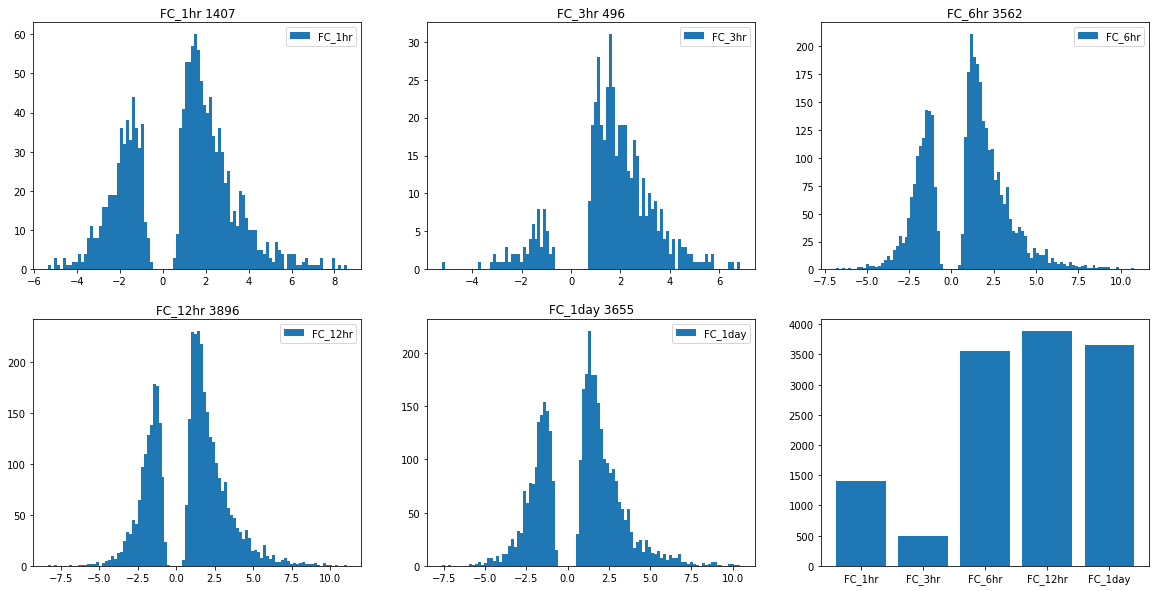

In [9]:
get_hist(data_folder+'ROOT/networks/drought_DEGs.csv', True)

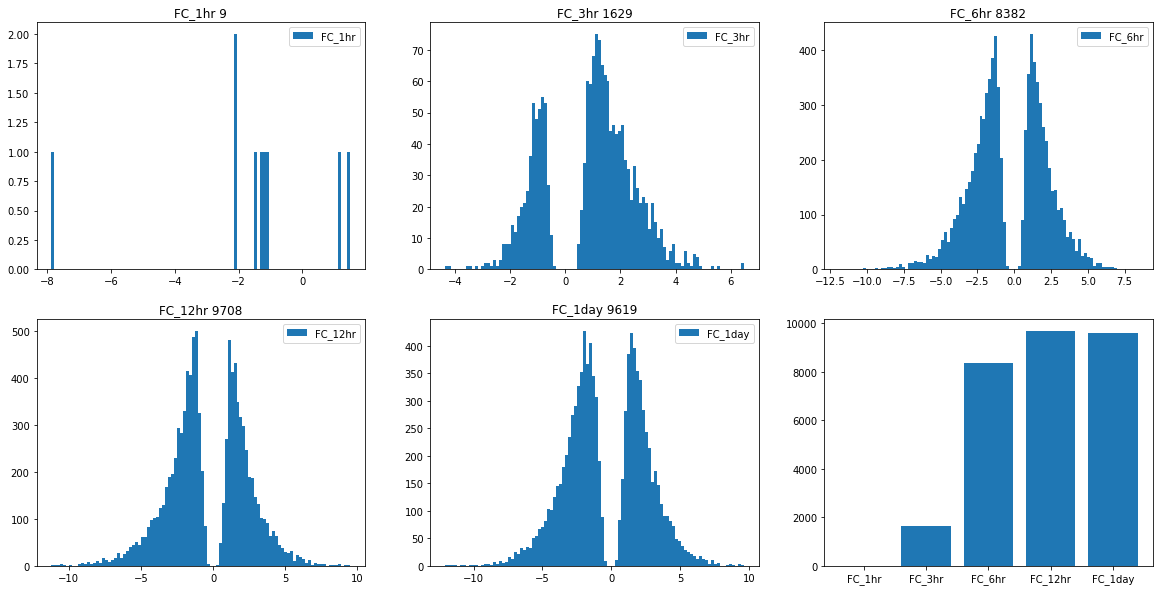

In [10]:
get_hist(data_folder+'SHOOT/networks/drought_DEGs.csv', True)

## High Fold Change Genes

In [11]:
def get_high_exp(filename, top_n = 5):
    rdf = pd.read_csv(filename)
    fc_points = ['FC_1hr','FC_3hr','FC_6hr','FC_12hr','FC_1day']
    pval_points = ['pval_1hr','pval_3hr','pval_6hr','pval_12hr','pval_1day']
    top_genes = []
    common_genes = []
    for i,fc_point in enumerate(fc_points):
        x = rdf[rdf[pval_points[i]] <= 0.05]
        print(fc_point, len(x))
        x = x.sort_values([fc_point], ascending=[False],  key=abs)
        top_x = x.head(n=top_n)[['Label','Symbol','Description', 'FC_1hr','FC_3hr','FC_6hr','FC_12hr','FC_1day']]
        top_genes+=list(top_x['Label'])
        if i==0:
            common_genes = list(top_x['Label'])
        else:
            common_genes = list(set(common_genes) & set(list(top_x['Label'])))
        display(HTML(top_x.to_html()))
    return list(set(top_genes)), common_genes

In [12]:
root_top, root_tc = get_high_exp(data_folder+'ROOT/networks/drought_full.csv')
print(root_top, root_tc)

shoot_top,shoot_tc = get_high_exp(data_folder+'SHOOT/networks/drought_full.csv')
print(shoot_top, shoot_tc)

FC_1hr 1171


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
2897,Os12g0617250,NaN,Hypothetical gene.,8.559506,6.861108,8.806450,8.941350,9.317780
2128,Os10g0548100,NaN,Similar to DM280 protein.,8.217073,6.605546,8.920313,9.740181,10.139549
2407,Os02g0733900,OsSYL2,Conserved hypothetical protein.,7.992144,5.420862,10.814451,11.064368,10.476991
2927,Os09g0518000,NaN,Similar to indole-3-acetate beta-glucosyltransferase.,7.956181,4.484918,9.291803,9.689648,8.768482
2050,Os11g0701200,C00481,"Glycoside hydrolase, family 18 protein.",7.889374,5.732905,9.150845,9.067519,9.165315


FC_3hr 453


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
2897,Os12g0617250,NaN,Hypothetical gene.,8.559506,6.861108,8.806450,8.941350,9.317780
2128,Os10g0548100,NaN,Similar to DM280 protein.,8.217073,6.605546,8.920313,9.740181,10.139549
2472,Os01g0832600,NaN,Similar to Leucoanthocyanidin dioxygenase-like protein.,4.218337,6.483464,6.564200,5.985730,6.414781
2050,Os11g0701200,C00481,"Glycoside hydrolase, family 18 protein.",7.889374,5.732905,9.150845,9.067519,9.165315
894,Os12g0472366,NaN,Hypothetical protein.,7.224222,5.678674,7.413863,7.146646,6.953982


FC_6hr 2902


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
2407,Os02g0733900,OsSYL2,Conserved hypothetical protein.,7.992144,5.420862,10.814451,11.064368,10.476991
1237,Os05g0442400,"MID1, OsMYB-1","R-R-type MYB-like transcription factor, Response to drought stress during reproductive development",7.411091,5.219316,9.873814,9.960919,9.994271
343,Os07g0154100,OsNCED4,Similar to Viviparous-14.,7.424231,5.639306,9.843118,10.394972,9.974243
2927,Os09g0518000,NaN,Similar to indole-3-acetate beta-glucosyltransferase.,7.956181,4.484918,9.291803,9.689648,8.768482
741,Os07g0687900,"OsGolS2, wsi76, WSI76, OsGolS1",WSI76 protein induced by water stress.,5.394205,5.132974,9.226066,9.611937,9.860929


FC_12hr 2944


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
2407,Os02g0733900,OsSYL2,Conserved hypothetical protein.,7.992144,5.420862,10.814451,11.064368,10.476991
343,Os07g0154100,OsNCED4,Similar to Viviparous-14.,7.424231,5.639306,9.843118,10.394972,9.974243
1237,Os05g0442400,"MID1, OsMYB-1","R-R-type MYB-like transcription factor, Response to drought stress during reproductive development",7.411091,5.219316,9.873814,9.960919,9.994271
2128,Os10g0548100,NaN,Similar to DM280 protein.,8.217073,6.605546,8.920313,9.740181,10.139549
2927,Os09g0518000,NaN,Similar to indole-3-acetate beta-glucosyltransferase.,7.956181,4.484918,9.291803,9.689648,8.768482


FC_1day 2538


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
2407,Os02g0733900,OsSYL2,Conserved hypothetical protein.,7.992144,5.420862,10.814451,11.064368,10.476991
2128,Os10g0548100,NaN,Similar to DM280 protein.,8.217073,6.605546,8.920313,9.740181,10.139549
1237,Os05g0442400,"MID1, OsMYB-1","R-R-type MYB-like transcription factor, Response to drought stress during reproductive development",7.411091,5.219316,9.873814,9.960919,9.994271
343,Os07g0154100,OsNCED4,Similar to Viviparous-14.,7.424231,5.639306,9.843118,10.394972,9.974243
1977,Os02g0649300,"HOX24, Oshox24, OsHox24, OsSLI1","HD-ZIP I protein, Transcription activator, Stress response, Panicle development",6.928596,5.312410,9.171124,9.686395,9.903072


['Os12g0472366', 'Os07g0687900', 'Os10g0548100', 'Os01g0832600', 'Os12g0617250', 'Os07g0154100', 'Os09g0518000', 'Os11g0701200', 'Os02g0649300', 'Os02g0733900', 'Os05g0442400'] []
FC_1hr 8


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
1125,Os03g0826900,NaN,Conserved hypothetical protein.,-7.871690,1.760135,4.356712,5.540690,3.515800
7840,Os12g0428000,STR7,Similar to senescence-associated protein DIN1.,-2.109229,1.014676,3.053395,2.848738,1.280712
2481,Os10g0565150,NaN,Hypothetical gene.,-2.107279,0.151039,0.267400,2.253165,2.708408
7337,Os03g0741050,NaN,Non-protein coding transcript.,1.488626,2.978165,2.579346,2.063620,2.128536
6022,Os04g0679400,NaN,Similar to H0801D08.15 protein.,-1.425678,1.790658,2.687911,3.711239,3.150422


FC_3hr 1443


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
8795,Os01g0783700,NaN,Similar to EF-hand Ca2+-binding protein CCD1.,3.528274,6.478747,4.428567,6.683368,6.904810
4691,Os07g0561300,OsMsr9,Cyclin-like F-box domain containing protein.,-1.404140,5.589622,4.474171,5.250185,5.903137
3666,Os03g0437200,ZFP36,"C2H2-type zinc finger protein, Abscisic acid-induced antioxidant defence, Water stress and oxidative stress tolerance",2.333088,5.295616,3.393726,6.024450,6.621511
5195,Os03g0676400,OsVQ13,VQ domain containing protein.,1.497423,4.892040,3.343689,5.774879,4.799763
7522,Os01g0389700,NaN,Protein of unknown function DUF679 family protein.,0.017600,4.815488,1.928878,3.086668,4.173841


FC_6hr 7554


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
6265,Os04g0354600,NaN,Similar to Acyl CoA reductase-like protein.,-0.072915,-1.103089,-11.881566,-11.203657,-11.625083
4432,Os06g0317600,NaN,Similar to Similarity.,-1.151189,-2.921774,-10.198887,-10.943190,-9.868236
3508,Os01g0195400,NaN,Harpin-induced 1 domain containing protein.,-0.264670,-0.387927,-10.195853,-10.495534,-6.605988
3473,Os12g0441600,NaN,"O-methyltransferase, family 2 domain containing protein.",-0.353820,-1.871290,-10.127832,-8.110573,-7.482550
3874,Os01g0842400,Oslacc,"Similar to Laccase (EC 1.10.3.2)., Similar to cDNA clone:J013170B10, full insert sequence.",-0.403293,-0.710708,-9.819517,-7.767427,-6.003701


FC_12hr 8606


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
6265,Os04g0354600,NaN,Similar to Acyl CoA reductase-like protein.,-0.072915,-1.103089,-11.881566,-11.203657,-11.625083
7697,Os09g0307300,NaN,"Targeting for Xklp2 family protein., Similar to Microtubule-associated protein.",0.176174,0.228911,-7.100663,-11.137018,-10.580853
4432,Os06g0317600,NaN,Similar to Similarity.,-1.151189,-2.921774,-10.198887,-10.943190,-9.868236
3627,Os08g0460000,OsGLP1,Similar to Germin-like protein 1 precursor.,-1.344408,-1.997652,-5.474527,-10.688435,-10.132270
5621,Os03g0658800,CYP87C2,"Cytochrome P450 family protein., Hypothetical conserved gene.",-0.855596,-0.859837,-7.825119,-10.676390,-11.462290


FC_1day 8319


,Label,Symbol,Description,FC_1hr,FC_3hr,FC_6hr,FC_12hr,FC_1day
1503,Os08g0247600,NaN,"Leucine-rich repeat, N-terminal domain containing protein.",0.254397,-1.774896,-7.862565,-9.806333,-12.046140
6265,Os04g0354600,NaN,Similar to Acyl CoA reductase-like protein.,-0.072915,-1.103089,-11.881566,-11.203657,-11.625083
5621,Os03g0658800,CYP87C2,"Cytochrome P450 family protein., Hypothetical conserved gene.",-0.855596,-0.859837,-7.825119,-10.676390,-11.462290
7524,Os08g0489300,NaN,"Methyladenine glycosylase domain containing protein., Similar to GMP synthase.",-0.296691,-0.283471,-5.103137,-8.886321,-11.280410
8338,Os02g0589700,NaN,Lecithin:cholesterol/phospholipid:diacylglycerol acyltransferase domain containing protein.,-0.234886,-1.207661,-7.137084,-10.511093,-10.904580


['Os01g0195400', 'Os01g0783700', 'Os07g0561300', 'Os06g0317600', 'Os12g0441600', 'Os08g0460000', 'Os03g0658800', 'Os12g0428000', 'Os03g0676400', 'Os04g0679400', 'Os09g0307300', 'Os10g0565150', 'Os01g0842400', 'Os03g0437200', 'Os03g0741050', 'Os01g0389700', 'Os08g0489300', 'Os02g0589700', 'Os04g0354600', 'Os03g0826900', 'Os08g0247600'] []


##Top Modules for Drought

In [13]:
def get_module_dist(filename):
    rdf = pd.read_csv(filename)
    fc_points = ['FC_1hr','FC_3hr','FC_6hr','FC_12hr','FC_1day']
    pval_points = ['pval_1hr','pval_3hr','pval_6hr','pval_12hr','pval_1day']
    modules = list(set(rdf['WGCNA_Modules']))
    modules = [x for x in modules if x is not np.nan]
    fig = plt.figure(figsize=(30,10))
    for i,fc_point in enumerate(fc_points):
        up_fc = []
        dn_fc = []
        total_fc = []
        for module in modules:
            up_no = len(rdf[(rdf['WGCNA_Modules'] == module) & (rdf[pval_points[i]]<=0.05) & (rdf[fc_point]>=1)])
            dn_no = len(rdf[(rdf['WGCNA_Modules'] == module) & (rdf[pval_points[i]]<=0.05) & (rdf[fc_point]<=-1)])
            up_fc.append(up_no)
            dn_fc.append(-1*dn_no)
            total_fc.append(up_no if up_no > dn_no else -1*dn_no)
        modules_st = [x for _, x in sorted(zip(total_fc, modules))]
        up_fc_st = [x for _, x in sorted(zip(total_fc, up_fc))]
        dn_fc_st = [x for _, x in sorted(zip(total_fc, dn_fc))]

        ax = plt.subplot(2,3,i+1)
        ax.bar(range(len(modules)), up_fc_st, width=1, color='r', edgecolor = "black")
        ax.bar(range(len(modules)), dn_fc_st, width=1, color='b', edgecolor = "black")
        ax.set_xticks(range(len(modules_st)))
        ax.set_xticklabels(modules_st, rotation=45)
        plt.title(fc_point)
    plt.show()
    return

###Root Tissue 

Up: Magenta, Black, GreenYellow

Down: Brown, Salmon, Turquoise

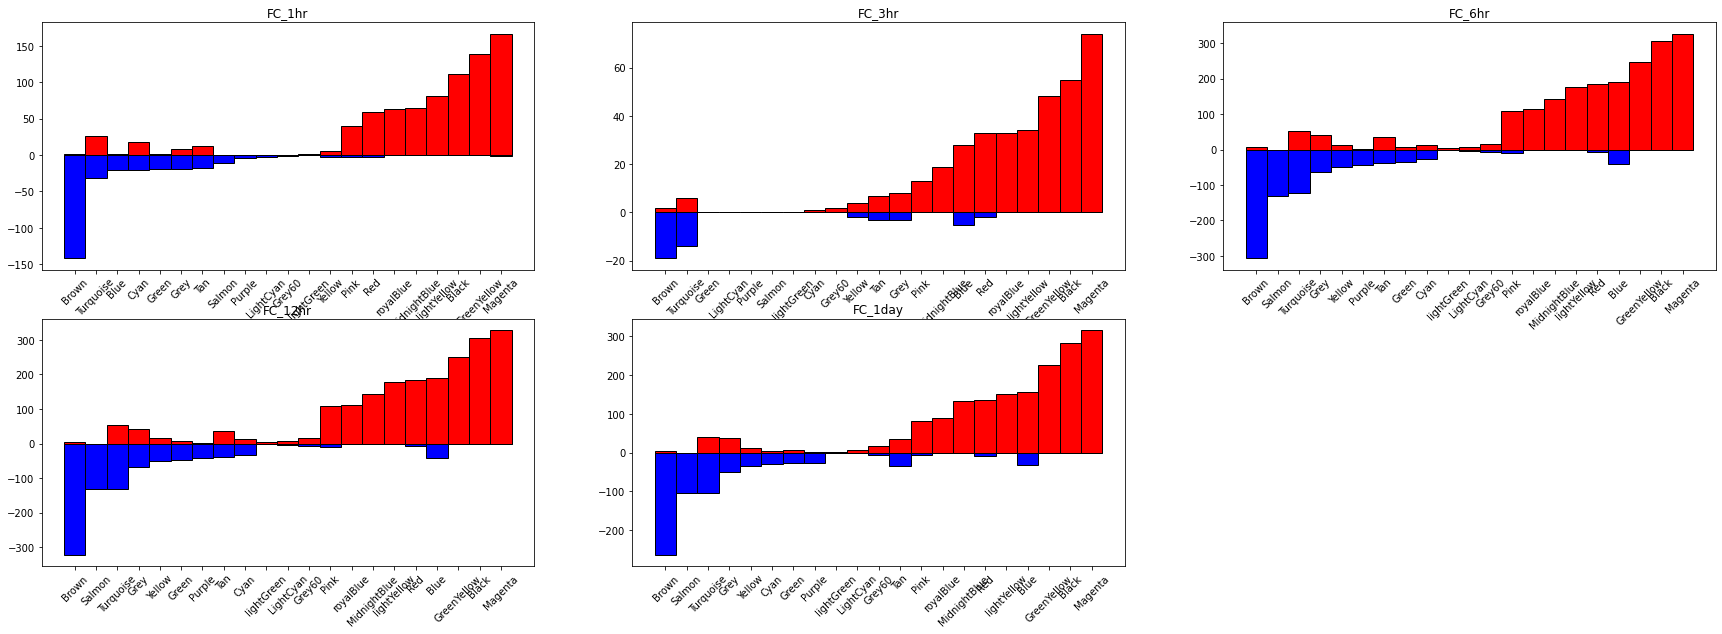

In [14]:
get_module_dist(data_folder+'ROOT/networks/drought_full.csv')

###Shoot Tissue
Up: Turquoise, Red, Yellow | Salmon-Strange

Down: Blue, Brown, Black

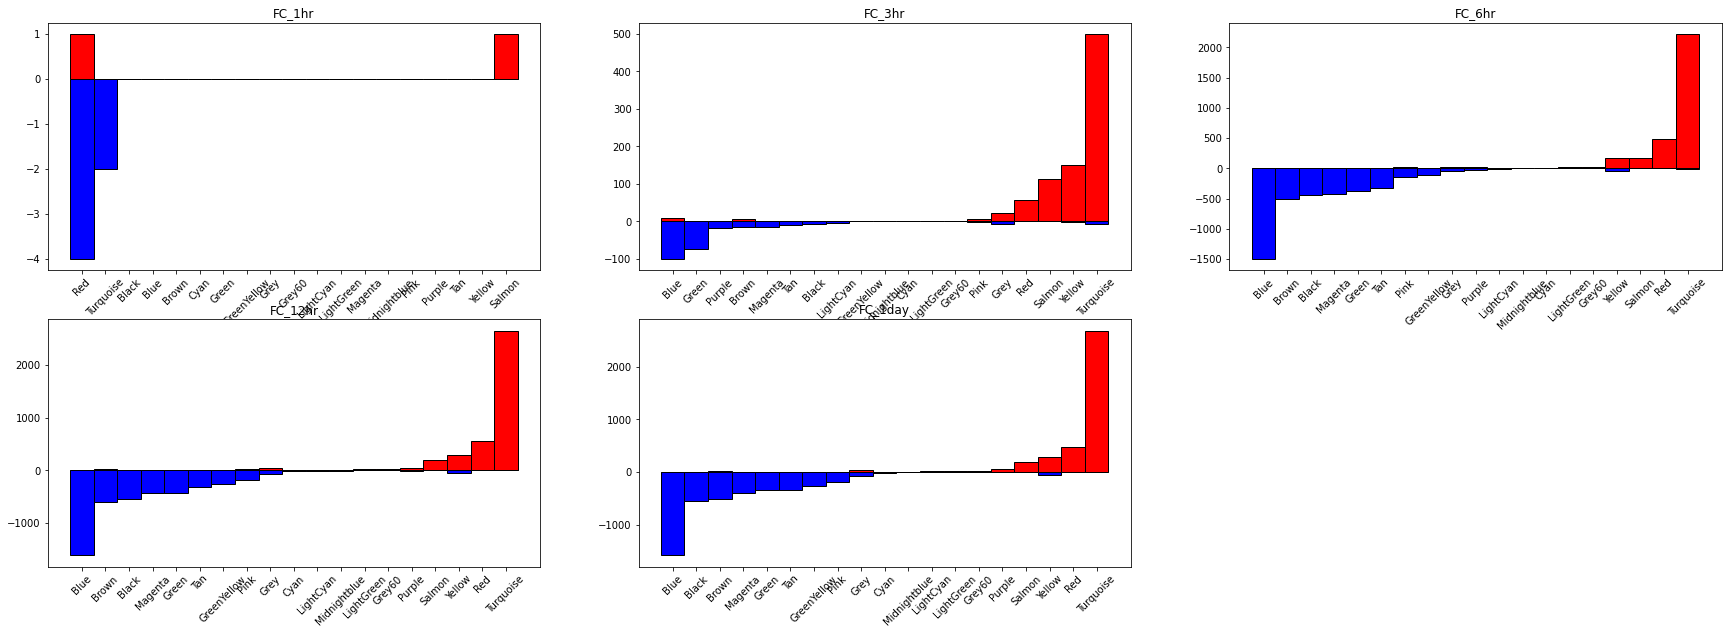

In [15]:
get_module_dist(data_folder+'SHOOT/networks/drought_full.csv')

## Percentage Presence of Each Module

In [27]:
def get_module_perc(filename, mod_file='ROOT/Root_cluster_degree.csv'):
    rdf = pd.read_csv(filename)
    tdf = pd.read_csv(data_folder+mod_file)
    fc_points = ['FC_1hr','FC_3hr','FC_6hr','FC_12hr','FC_1day']
    pval_points = ['pval_1hr','pval_3hr','pval_6hr','pval_12hr','pval_1day']
    modules = list(set(rdf['WGCNA_Modules']))
    modules = [x for x in modules if x is not np.nan]
    fig = plt.figure(figsize=(30,15))
    for i,fc_point in enumerate(fc_points):
        up_fc = []
        dn_fc = []
        total = []
        total_fc = []
        for module in modules:
            total_no = len(tdf[(tdf['WGCNA_Modules'] == module)])
            up_no = len(rdf[(rdf['WGCNA_Modules'] == module) & (rdf[pval_points[i]]<=0.05) & (rdf[fc_point]>=1)])
            dn_no = len(rdf[(rdf['WGCNA_Modules'] == module) & (rdf[pval_points[i]]<=0.05) & (rdf[fc_point]<=-1)])
            up_fc.append(up_no/total_no * 100)
            dn_fc.append(dn_no/total_no * 100)
            total_fc.append((up_no+dn_no)/total_no * 100)
            total.append(total_no)
        modules_st = [x for _, x in sorted(zip(total_fc, modules), key=lambda pair: pair[0])]
        up_fc_st = [x for _, x in sorted(zip(total_fc, up_fc), key=lambda pair: pair[0])]
        dn_fc_st = [x for _, x in sorted(zip(total_fc, dn_fc), key=lambda pair: pair[0])]

        ax = plt.subplot(2,3,i+1)
        p1 = ax.bar(range(len(modules)), up_fc_st, width=0.8, color='r')
        p2 = ax.bar(range(len(modules)), dn_fc_st, width=0.8, color='b', bottom=up_fc_st)
        ax.set_xticks(range(len(modules_st)))
        ax.set_xticklabels(modules_st, rotation=45)
        ax.bar_label(p1, label_type='center', fmt='%.1f')
        ax.bar_label(p2, label_type='center', fmt='%.1f')
        plt.ylim(0, 100)
        plt.title(fc_point)
    plt.show()
    return

### Root Tissue

#### Down-Reg
**Salmon**: organic substance metabolic process (GO:0071704) (5.76e-01)\
**Brown**: arabinose metabolic process (GO:0019566) (1.90e+01)

#### Up-Reg
**Light Yellow**: chorismate metabolic process (GO:0046417) (3.65e+01)\
**Magenta**: positive regulation of abscisic acid-activated signaling pathway (4.37e+01)\
**Green Yellow**: carotene metabolic process (GO:0016119) (2.33e+01)

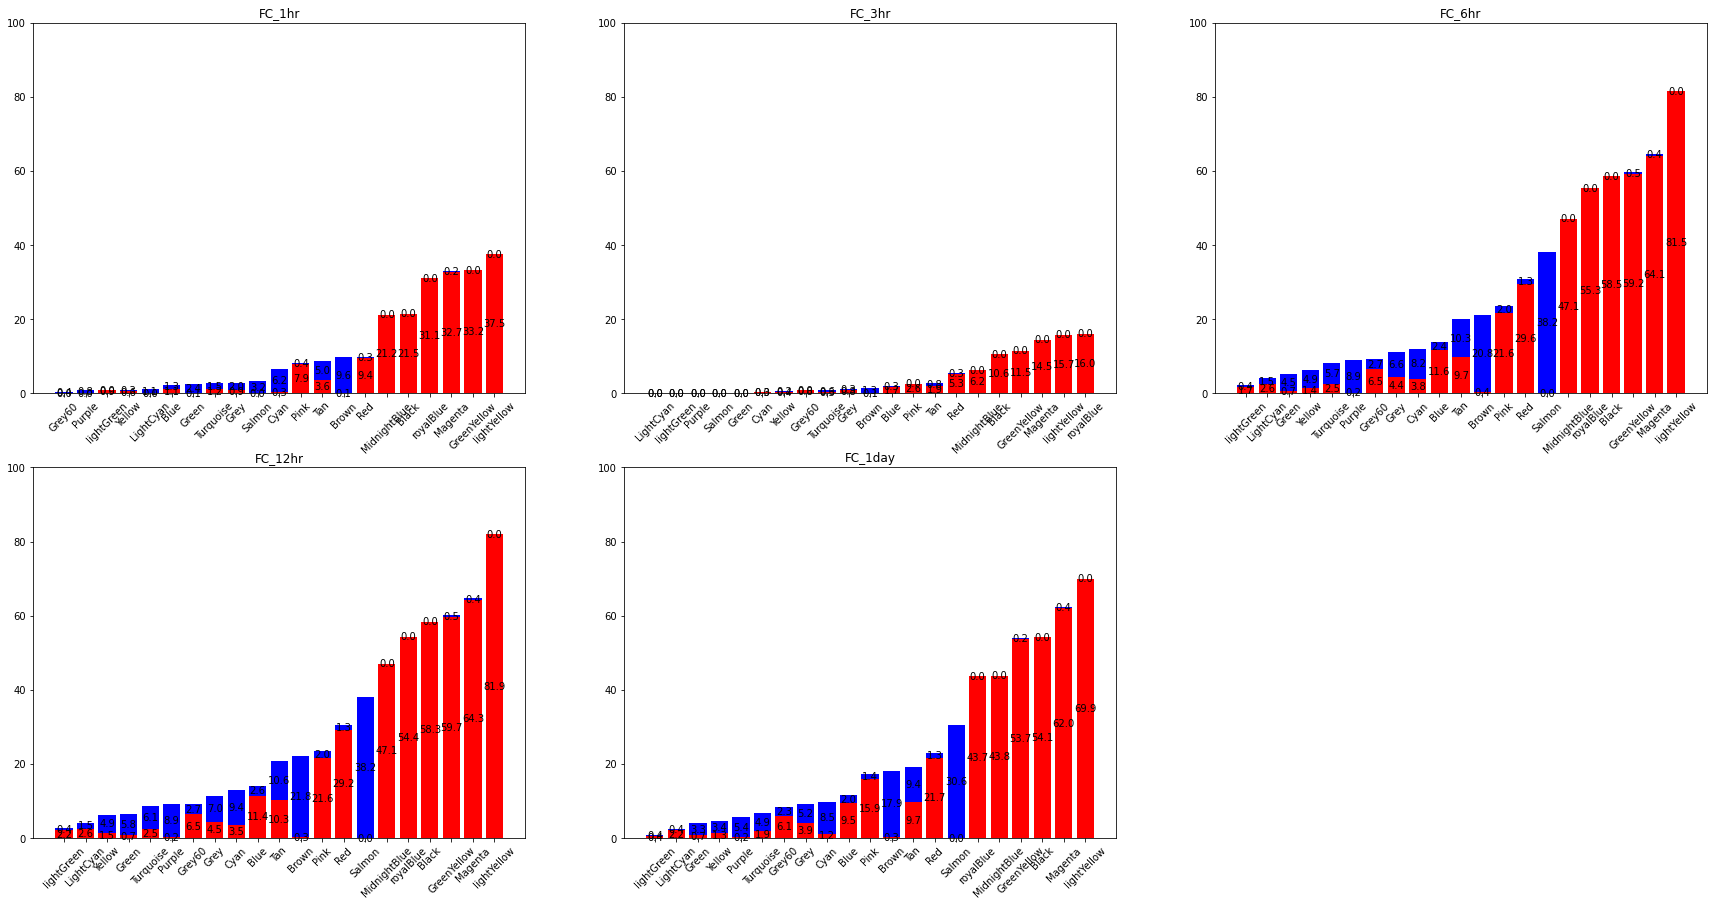

In [28]:
get_module_perc(data_folder+'ROOT/networks/drought_full.csv')

### Shoot Tissue

#### Down-Reg
**Magenta**: xylem development (GO:0010089) (4.55e+01)\
**Tan**: plastid transcription (GO:0042793) (4.03e+01) (photosynthesis)\
**Black**: sialylation (GO:0097503) (4.25e+01) (pollination)

#### Up-Reg
**Turquoise**: lysosomal microautophagy (GO:0016237) (1.02e+01)\
**Red**: glyoxylate metabolic process (GO:0046487) (6.25e+01)

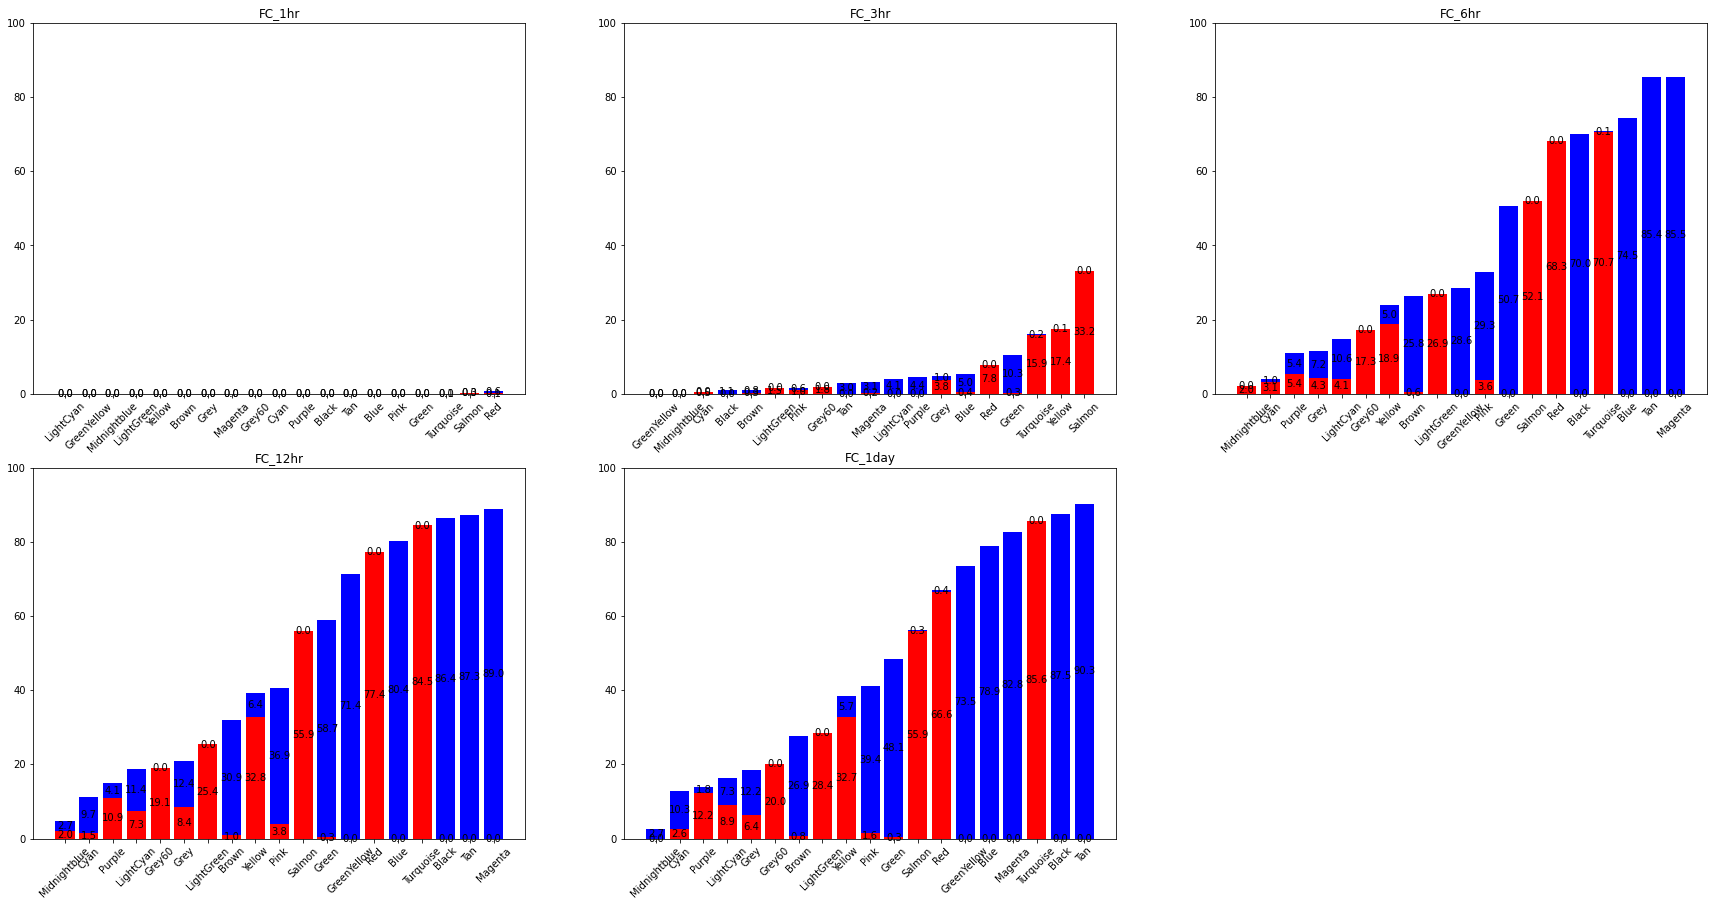

In [29]:
get_module_perc(data_folder+'SHOOT/networks/drought_full.csv', 'SHOOT/Shoot_cluster_degree.csv')

In [30]:
def get_top_modules(modules, filename, module_loc):
    rdf = pd.read_csv(filename)
    topgene_list = []
    for i, module in enumerate(modules):
        gene_list = list(rdf[(rdf['WGCNA_Modules'] == module)]['Label'])
        module_fn = module_loc+module+"_full.csv" if os.path.exists(module_loc+module+"_full.csv") else module_loc+module.replace(" ","").lower()+"_full.csv"
        mdf = pd.read_csv(module_fn)
        mdf = mdf[mdf['Label'].isin(gene_list)]
        print(len(mdf))
        mdf = mdf.sort_values(['kTotal'], ascending=[False])
        top_mdf = mdf.head(n=5)
        topgene_list+=list(top_mdf['Label'])
        print(module)
        display(HTML(top_mdf.to_html()))
    return list(set(topgene_list))

In [31]:
gl = get_top_modules(['lightYellow','Magenta','GreenYellow'],data_folder+'ROOT/networks/drought_full.csv',data_folder+'ROOT/high_degree_module_hrr/')

99
lightYellow


,id,Label,TF,KEGG,Symbol,kTotal,Rank,WGCNA_Modules,IntraModular Connectivity,Description,GO,MapMan,MSU_LOC
28,28,Os06g0166900,NaN,NaN,NaN,54.565030,660,lightYellow,8.883651,"Protein kinase, core domain containing protein.","Biological Process: protein phosphorylation (GO:0006468), Molecular Function: protein kinase activity (GO:0004672), Molecular Function: protein serine/threonine kinase activity (GO:0004674), Molecular Function: protein tyrosine kinase activity (GO:0004713), Molecular Function: ATP binding (GO:0005524), Molecular Function: transferase activity, transferring phosphorus-containing groups (GO:0016772)",['protein.postranslational modification.kinase.receptor like cytoplasmatic kinase VII'],LOC_Os06g07070
13,13,Os04g0618200,NaN,"Amino sugar and nucleotide sugar metabolism, Metabolic pathways",NaN,52.777992,708,lightYellow,11.070904,"Similar to cDNA clone:J013046D23, full insert sequence., Similar to H0313F03.11 protein.","Biological Process: galactose metabolic process (GO:0006012), Biological Process: cellular metabolic process (GO:0044237), Molecular Function: nucleotide binding (GO:0000166), Molecular Function: catalytic activity (GO:0003824), Molecular Function: UDP-glucose 4-epimerase activity (GO:0003978), Molecular Function: coenzyme binding (GO:0050662)",['cell wall.precursor synthesis.MUR4'],LOC_Os04g52730
11,11,Os12g0168100,NaN,NaN,ERF124,50.887694,762,lightYellow,11.585929,Similar to AP2 domain containing protein RAP2.6 (Fragment).,"Biological Process: regulation of transcription, DNA-dependent (GO:0006355), Molecular Function: DNA binding (GO:0003677), Molecular Function: sequence-specific DNA binding transcription factor activity (GO:0003700)",['not assigned.unknown'],LOC_Os12g07030
8,8,Os05g0287800,NaN,NaN,NaN,50.314214,785,lightYellow,12.056254,Similar to Phosphatidic acid phosphatase-like protein.,NaN,['misc.acid and other phosphatases'],LOC_Os05g21180
5,5,Os02g0173800,NaN,NaN,NaN,47.697191,881,lightYellow,12.881202,"Protein of unknown function DUF284, transmembrane eukaryotic family protein.",Cellular Component: membrane (GO:0016020),['transport.p- and v-ATPases'],LOC_Os02g07750


98
Magenta


,id,Label,TF,KEGG,Symbol,kTotal,Rank,WGCNA_Modules,IntraModular Connectivity,Description,GO,MapMan,MSU_LOC
66,66,Os04g0476600,NaN,NaN,OsGRAM26,61.095267,491,Magenta,14.505611,C2 calcium-dependent membrane targeting domain containing protein.,Molecular Function: protein binding (GO:0005515),['not assigned.unknown'],LOC_Os04g40070
21,21,Os02g0740600,NaN,NaN,NaN,54.214821,666,Magenta,20.091195,Conserved hypothetical protein.,NaN,['not assigned.unknown'],LOC_Os02g50710
11,11,Os04g0485800,NaN,NaN,NaN,53.875287,679,Magenta,23.286974,Cyclin-like F-box domain containing protein.,Molecular Function: protein binding (GO:0005515),['protein.degradation.ubiquitin.E3.SCF.FBOX'],LOC_Os04g40910
42,42,Os06g0662550,NaN,NaN,NaN,51.785827,741,Magenta,16.985538,Conserved hypothetical protein.,NaN,['not assigned.unknown'],LOC_Os06g45184
0,0,Os05g0421450,NaN,NaN,NaN,50.463320,779,Magenta,31.660232,Hypothetical protein.,NaN,NaN,None


96
GreenYellow


,id,Label,TF,KEGG,Symbol,kTotal,Rank,WGCNA_Modules,IntraModular Connectivity,Description,GO,MapMan,MSU_LOC
64,64,Os01g0863300,MYB,NaN,NaN,41.263503,1178,GreenYellow,8.822016,Similar to MCB2 protein.,"Biological Process: regulation of transcription, DNA-dependent (GO:0006355), Molecular Function: DNA binding (GO:0003677), Molecular Function: protein binding (GO:0005515)",['RNA.regulation of transcription.MYB-related transcription factor family'],LOC_Os01g64360
2,2,Os07g0561300,NaN,NaN,OsMsr9,40.093130,1223,GreenYellow,18.832832,Cyclin-like F-box domain containing protein.,Molecular Function: protein binding (GO:0005515),['not assigned.unknown'],LOC_Os07g37400
48,48,Os02g0733900,NaN,NaN,OsSYL2,40.060113,1225,GreenYellow,10.131066,Conserved hypothetical protein.,NaN,['not assigned.unknown'],LOC_Os02g50110
26,26,Os01g0513400,NaN,NaN,NaN,37.270519,1420,GreenYellow,12.051136,Protein of unknown function DUF789 family protein.,NaN,['not assigned.unknown'],LOC_Os01g33000
5,5,Os03g0792800,NaN,NaN,NaN,34.953354,1584,GreenYellow,18.091704,"Beta-1, 3-glucanase-like protein.","Biological Process: carbohydrate metabolic process (GO:0005975), Molecular Function: catalytic activity (GO:0003824), Molecular Function: hydrolase activity, hydrolyzing O-glycosyl compounds (GO:0004553), Molecular Function: cation binding (GO:0043169)","['misc.beta 1,3 glucan hydrolases.glucan endo-1,3-beta-glucosidase']",LOC_Os03g57880


In [32]:
gl

['Os06g0662550',
 'Os06g0166900',
 'Os03g0792800',
 'Os02g0173800',
 'Os04g0618200',
 'Os04g0485800',
 'Os05g0421450',
 'Os02g0733900',
 'Os05g0287800',
 'Os07g0561300',
 'Os01g0863300',
 'Os01g0513400',
 'Os02g0740600',
 'Os04g0476600',
 'Os12g0168100']

In [33]:
sgl = get_top_modules(['Magenta','Tan','Black'],data_folder+'SHOOT/networks/drought_full.csv',data_folder+'SHOOT/high_degree_module_hrr/')

100
Magenta


,id,Label,TF,KEGG,Symbol,kTotal,Rank,WGCNA_Modules,IntraModular Connectivity,Description,GO,MapMan,MSU_LOC
47,47,Os12g0115700,NaN,"Flavonoid biosynthesis, Metabolic pathways, Biosynthesis of secondary metabolites",NaN,142.597744,623,Magenta,30.419471,Chalcone isomerase domain containing protein.,"Biological Process: flavonoid biosynthetic process (GO:0009813), Biological Process: cellular modified amino acid biosynthetic process (GO:0042398), Molecular Function: intramolecular lyase activity (GO:0016872), Molecular Function: chalcone isomerase activity (GO:0045430)",['secondary metabolism.flavonoids.chalcones'],LOC_Os12g02370
41,41,Os06g0289900,NaN,NaN,NaN,142.114148,630,Magenta,31.472668,UDP-glucuronosyl/UDP-glucosyltransferase family protein.,"Biological Process: metabolic process (GO:0008152), Molecular Function: transferase activity, transferring hexosyl groups (GO:0016758)",['misc.UDP glucosyl and glucoronyl transferases'],LOC_Os06g18670
50,50,Os03g0399800,NaN,NaN,NaN,135.940327,722,Magenta,30.075884,Mannose-binding lectin domain containing protein.,NaN,['not assigned.unknown'],LOC_Os03g28160
43,43,Os05g0176100,NaN,NaN,CESA1,122.008328,931,Magenta,31.140871,"Similar to Cellulose synthase BoCesA1., Similar to RSW1-like cellulose synthase catalytic subunit (Fragment)., Similar to Cellulose synthase BoCesA8.","Biological Process: cellulose biosynthetic process (GO:0030244), Cellular Component: membrane (GO:0016020), Molecular Function: cellulose synthase (UDP-forming) activity (GO:0016760),",['cell wall.cellulose synthesis.cellulose synthase'],LOC_Os05g08370
24,24,Os06g0707200,NaN,NaN,NaN,118.172943,995,Magenta,36.312018,"Glycosyltransferase AER61, uncharacterized domain containing protein.","Molecular Function: transferase activity, transferring glycosyl groups (GO:0016757)",['not assigned.unknown'],LOC_Os06g49320


100
Tan


,id,Label,TF,KEGG,Symbol,kTotal,Rank,WGCNA_Modules,IntraModular Connectivity,Description,GO,MapMan,MSU_LOC
12,12,Os02g0529900,NaN,NaN,NaN,122.946225,916,Tan,14.535320,Pentatricopeptide repeat domain containing protein.,Molecular Function: binding (GO:0005488),"['RNA.regulation of transcription.MYB domain transcription factor family', 'transport.misc']",LOC_Os02g32780
54,54,Os03g0786400,NaN,NaN,"DST, OsDST",99.414756,1438,Tan,10.475175,"C2H2 zinc finger transcription factor, Drought and salt tolerance, Stomatal aperture control",Molecular Function: metal ion binding (GO:0046872),['not assigned.unknown'],LOC_Os03g57240
82,82,Os02g0589700,NaN,Glycerophospholipid metabolism,NaN,94.899012,1565,Tan,8.201846,Lecithin:cholesterol/phospholipid:diacylglycerol acyltransferase domain containing protein.,"Biological Process: lipid metabolic process (GO:0006629), Molecular Function: O-acyltransferase activity (GO:0008374)","[""lipid metabolism.'exotics' (steroids, squalene etc).phosphatidylcholinesterol O-acyltransferase""]",LOC_Os02g37700
9,9,Os03g0232600,NaN,NaN,"ELF1, OsPUB31, OsPUB75, TUD1, OsTUD1",91.952031,1649,Tan,15.569195,"U-Box E3 ubiquitin ligase, Regulation of brassinosteroid-mediated growth","Biological Process: protein ubiquitination (GO:0016567), Molecular Function: ubiquitin-protein transferase activity (GO:0004842), Molecular Function: binding (GO:0005488)",['protein.degradation.ubiquitin.E3.RING'],LOC_Os03g13010
25,25,Os10g0196000,NaN,NaN,NaN,87.652127,1781,Tan,13.286929,Similar to Cytochrome P450 CYP98A7.,"Biological Process: oxidation-reduction process (GO:0055114), Molecular Function: iron ion binding (GO:0005506), Molecular Function: electron carrier activity (GO:0009055), Molecular Function: oxidoreductase activity, acting on paired donors, with incorporation or reduction of molecular oxygen (GO:0016705), Molecular Function: heme binding (GO:0020037)",['not assigned.unknown'],LOC_Os10g12050


100
Black


,id,Label,TF,KEGG,Symbol,kTotal,Rank,WGCNA_Modules,IntraModular Connectivity,Description,GO,MapMan,MSU_LOC
1,1,Os06g0287700,NaN,NaN,NaN,127.884410,834,Black,30.732420,"Similar to NBS-LRR disease resistance protein homologue (Fragment)., Non-protein coding transcript., Similar to Nbs-lrr disease resistance protein (Fragment).","Biological Process: defense response (GO:0006952), Molecular Function: ADP binding (GO:0043531),",['stress.biotic'],LOC_Os06g17970
14,14,Os01g0142100,NaN,NaN,NaN,122.026653,930,Black,25.964586,"Peptidase M50 family protein., Similar to Metalloendopeptidase.","Biological Process: proteolysis (GO:0006508), Molecular Function: metalloendopeptidase activity (GO:0004222)",['protein.degradation'],LOC_Os01g04900
22,22,Os12g0151500,NaN,NaN,NaN,118.002095,1000,Black,23.502326,"Similar to Alpha-2, 8-sialyltransferase 8B (EC 2.4.99.-) (ST8Sia II) (Sialyltransferase X) (STX).","Biological Process: protein glycosylation (GO:0006486), Cellular Component: integral to Golgi membrane (GO:0030173), Molecular Function: sialyltransferase activity (GO:0008373)",['protein.glycosylation'],LOC_Os12g05550
7,7,Os06g0483500,NaN,NaN,NaN,115.518301,1062,Black,27.457680,Similar to H0124B04.15 protein.,NaN,['not assigned.unknown'],LOC_Os06g28840
63,63,Os07g0102100,NaN,NaN,HAK22,111.839128,1137,Black,18.450790,"Similar to Potassium transporter 22., Similar to Potassium transporter 1 (OsHAK1). Splice isoform 2.","Biological Process: potassium ion transmembrane transport (GO:0071805), Cellular Component: membrane (GO:0016020), Molecular Function: potassium ion transmembrane transporter activity (GO:0015079)",['transport.potassium'],LOC_Os07g01214


In [34]:
sgl

['Os05g0176100',
 'Os10g0196000',
 'Os12g0151500',
 'Os12g0115700',
 'Os02g0529900',
 'Os03g0399800',
 'Os02g0589700',
 'Os03g0232600',
 'Os06g0287700',
 'Os06g0289900',
 'Os06g0483500',
 'Os07g0102100',
 'Os03g0786400',
 'Os01g0142100',
 'Os06g0707200']

## TF